# Sprint 3

## Summary

In this notebook, I explored how to use an ALS-derived treelist to predict missing tree attributes, namely Diameter, Crown Base Height, and Species. I also compared a TLS (Terrestrial Laser Scanning) derived dataset to a field-derived dataset at Shaver Lake.

### Part 1: TLS vs. Field Data at Shaver Lake

In [36]:
# Task 1 - Your code here
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading the full plots inventory
plot_inventory = pd.read_csv("./01_plot_identification.csv")

# Specify our site of interest
site_name = "SHA"

# We only keep the inventory plots for Shaver Lake
shaver_inventory = plot_inventory.loc[plot_inventory.site_name == site_name, ['inventory_id', 'plot_blk']]
shaver_inventory.head()

,inventory_id,plot_blk
0,143_pre_SHA_burn3d,CAFKU_0143_20240721_1
1,140_pre_SHA_burn3d,CAFKU_0140_20240721_1
2,152_pre_SHA_burn3d,CAFKU_0152_20240721_1
3,147_pre_SHA_burn3d,CAFKU_0147_20240720_1
4,151_pre_SHA_burn3d,CAFKU_0151_20240720_1


In [37]:
# We sample the first 5 plots
shaver_sample = shaver_inventory.head()

# Load both the TLS and the field collected treelist
tls_treelist = pd.read_csv("./TLS_treelist.csv")
field_treelist = pd.read_csv("./03_tree.csv")

# Filter tls_treelist based on plot_blk in ind_sample
tls_treelist_shaver = tls_treelist.merge(shaver_sample[['plot_blk']], on='plot_blk', how='inner')

# Filter field_treelist based on inventory_id in ind_sample
field_treelist_shaver = field_treelist.merge(shaver_sample[['inventory_id']], on='inventory_id', how='inner')


Text(0.5, 1.0, 'TLS vs Field Data at Shaver Lake')

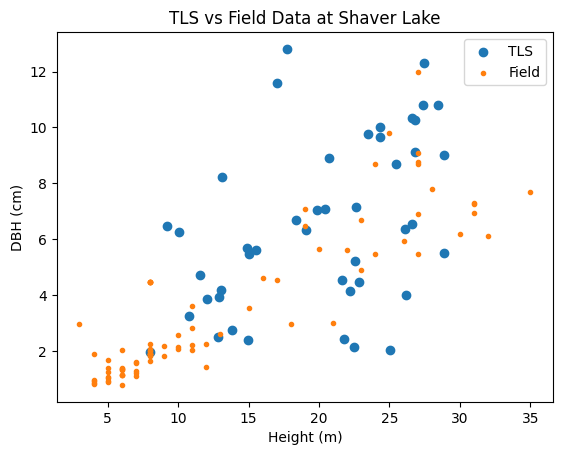

In [38]:
# Plot trees from both sources
fig, ax = plt.subplots()
plt.scatter(tls_treelist_shaver.H, tls_treelist_shaver.DBH/2.54, axes = ax, label = 'TLS')
plt.scatter(field_treelist_shaver.tree_ht, field_treelist_shaver.tree_dbh/10, axes = ax, marker = '.',label= 'Field')
plt.xlabel('Height (m)')
plt.ylabel('DBH (cm)')
plt.legend()
plt.title('TLS vs Field Data at Shaver Lake')

#### Our Thoughts
The plots comparing TLS and Field data for Shaver Lake and Independence Lake reveal notable differences in tree structure and measurement consistency. At Shaver Lake, the TLS and Field data show a broader range of both height and DBH values, with TLS generally capturing larger DBH measurements than the Field method for taller trees. This suggests that TLS may be more effective at capturing larger trees, or that there is a systematic overestimation in TLS measurements. In contrast, the Independence Lake plot showed a tighter clustering of values and a smaller overall range in DBH, with the TLS and Field data aligning more closely, though TLS still slightly overestimates DBH. 

The discrepancies between the two treelists may be due to differences in forest structure. Shaver Lake appears to have more mature, taller trees with greater DBH, possibly leading to occlusion or shadowing in TLS measurements. In contrast, Independence Lake may have a denser, younger forest where TLS and Field measurements are more easily matched. These observations generally align with what we found by comparing the two sites in previous sprints as well. Other factors such as terrain, scanner setup, and environmental conditions at the time of data collection could also contribute to these differences.


### Part 2: Modeling Diameter, Species, and CBH at Shaver Lake

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [40]:
ALS_treetops = pd.read_csv('./ALS_treetops.csv')
FF_treelist = pd.read_csv('FF_treelist_all.csv')
fia_ref_species_table = pd.read_csv('./REF_SPECIES.csv')

In [41]:
site_name = 'SHA'

# Filter ALS treetops by site
ALS_treetops_filter = ALS_treetops[ALS_treetops.site_name == site_name]

# For FastFuels treelist, filter by site
FF_treelist_filter = FF_treelist[FF_treelist.site_name == site_name]

# Rename height column for ALS file (if needed)
ALS_treetops_filter = ALS_treetops_filter.rename(columns={'height_m': 'HT'})

# Convert ALS treetops to a GeoDataFrame using coordinates (assumes columns X_4326 and Y_4326)
ALS_treetops_gdf = gpd.GeoDataFrame(
    ALS_treetops_filter,
    geometry=gpd.points_from_xy(ALS_treetops_filter.X_4326, ALS_treetops_filter.Y_4326),
    crs=4326
)

# Use the filtered FastFuels treelist as our training treelist
treelist = FF_treelist_filter
treelist.head()

,SPCD,DIA,HT,STATUSCD,CBH,CR,X,Y,geometry,site_name,X_4326,Y_4326
23266,814,14.732,9.7536,2,NaN,NaN,-2029248.192,1.811832e+06,POINT (-119.2807981866652 37.10055993214569),SHA,-119.280798,37.100560
23267,814,14.732,9.7536,2,NaN,NaN,-2029228.422,1.811843e+06,POINT (-119.2806115374424 37.10070078752966),SHA,-119.280612,37.100701
23268,122,NaN,NaN,2,NaN,NaN,-2029212.404,1.811821e+06,POINT (-119.280374586538 37.10054546366893),SHA,-119.280375,37.100545
23269,814,13.208,6.0960,1,2.13360,0.813356,-2029218.343,1.811834e+06,POINT (-119.2804745751547 37.10064118282663),SHA,-119.280475,37.100641
23270,814,13.970,5.7912,1,3.18516,0.534938,-2029244.407,1.811816e+06,POINT (-119.2807125425391 37.10043003743448),SHA,-119.280713,37.100430


## Model 1 – Predicting Diameter (DIA) from Height (HT)


In [42]:
# Diameter prediction: split treelist data into training and testing sets
independent_variables = ["HT"]
dependent_variable = "DIA"
include_variables = independent_variables + [dependent_variable]

trees_train, trees_test = train_test_split(treelist[include_variables].dropna(), test_size=0.2)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

# Train Random Forest model for diameter prediction
model_ht = RandomForestRegressor()
model_ht.fit(trees_train[independent_variables], trees_train[dependent_variable])

# Predict on test set and on ALS data
predicted_dbh_test = model_ht.predict(trees_test[independent_variables])
predicted_dbh = model_ht.predict(ALS_treetops_filter[independent_variables])

# Evaluate model performance: R^2 and RMSE on test set
r2 = model_ht.score(trees_test[independent_variables], trees_test[dependent_variable])
rmse = np.sqrt(((predicted_dbh_test - trees_test[dependent_variable])**2).mean())
print(f"Model R^2: {r2:.2f}")
print(f"Model RMSE: {rmse:.2f} (cm)")


Training set size: 45013
Test set size: 11254
Model R^2: 0.92
Model RMSE: 8.17 (cm)


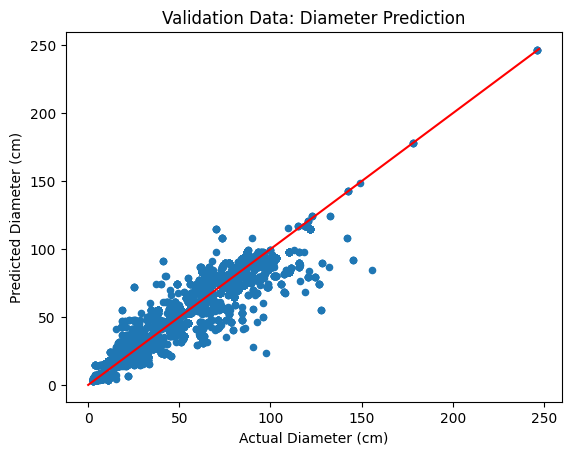

In [43]:
# Plot actual vs. predicted diameters on test data
fig, ax = plt.subplots()
trees_test = trees_test.copy()  # to avoid SettingWithCopyWarning
trees_test["predicted_diameter"] = predicted_dbh_test
trees_test.plot.scatter(x="DIA", y="predicted_diameter", ax=ax)
upper_dia_limit = max(trees_test["DIA"].max(), trees_test["predicted_diameter"].max()) + 1
ax.plot([0, upper_dia_limit], [0, upper_dia_limit], color='red')
ax.set_xlabel("Actual Diameter (cm)")
ax.set_ylabel("Predicted Diameter (cm)")
ax.set_title("Validation Data: Diameter Prediction")
plt.show()


Now, we apply our diameter model to the ALS treetops.

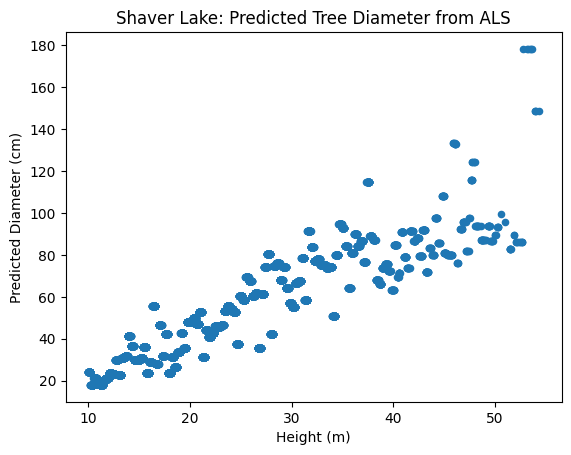

In [44]:
# Predict diameter for ALS-derived treetops
ALS_treetops_filter["predicted_diameter"] = predicted_dbh

# Plot predicted diameter versus height for ALS trees
fig, ax = plt.subplots()
ALS_treetops_filter.plot.scatter(x="HT", y="predicted_diameter", ax=ax)
ax.set_xlabel("Height (m)")
ax.set_ylabel("Predicted Diameter (cm)")
ax.set_title("Shaver Lake: Predicted Tree Diameter from ALS")
plt.show()

## Model 2 – Predicting Species Code (SPCD) from Height


Training set size: 45013
Test set size: 11254
                            precision    recall  f1-score   support

                 white fir       0.57      0.65      0.61      2594
                 grand fir       0.00      0.00      0.00        60
        California red fir       0.00      0.00      0.00         2
           western juniper       0.00      0.00      0.00         1
             western larch       0.00      0.00      0.00         1
             incense-cedar       0.69      0.77      0.73      4097
            lodgepole pine       0.84      0.50      0.63        42
              Jeffrey pine       0.86      0.07      0.13       263
                sugar pine       0.61      0.49      0.54       886
            ponderosa pine       0.71      0.73      0.72      2372
               Douglas-fir       0.51      0.09      0.16       229
           Pacific madrone       0.00      0.00      0.00         7
curlleaf mountain-mahogany       0.00      0.00      0.00        12
 

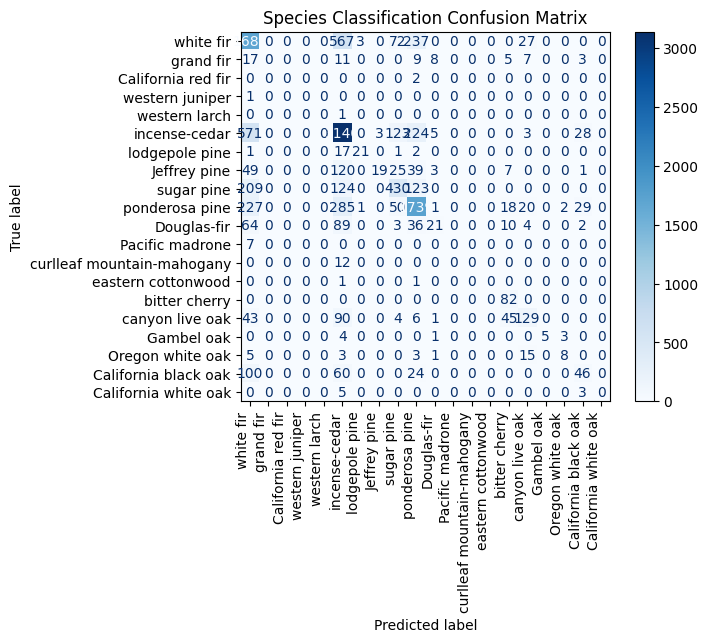

In [45]:

# Create a dictionary mapping SPCD to common species names using FIA reference table
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))

# Prepare data for species classification
independent_variables = ["HT"]
dependent_variable = "SPCD"
include_variables = independent_variables + [dependent_variable]

# Split FastFuels treelist data (filtered for SHA) into training and test sets
trees_train, trees_test = train_test_split(treelist[include_variables].dropna(), test_size=0.2)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

# Train a Random Forest Classifier for SPCD prediction
model_spcd = RandomForestClassifier()
model_spcd.fit(trees_train[independent_variables], trees_train[dependent_variable])

# Predict species on test set and on ALS data
predicted_spcd_test = model_spcd.predict(trees_test[independent_variables])
predicted_spcd = model_spcd.predict(ALS_treetops_filter[independent_variables])

# Evaluate classification performance with a classification report
unique_species = sorted(trees_test[dependent_variable].unique())
species_names = [spcd_to_common_name.get(spcd, f"Unknown ({spcd})") for spcd in unique_species]
report = classification_report(trees_test[dependent_variable], predicted_spcd_test, zero_division=0, target_names=species_names)
print(report)

# Display confusion matrix
cm = confusion_matrix(trees_test[dependent_variable], predicted_spcd_test)
disp = ConfusionMatrixDisplay(cm, display_labels=species_names)
disp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=90, ha='right')
plt.title("Species Classification Confusion Matrix")
plt.show()

The model appears to misclassify white fir frequently as Douglas-fir, grand fir, and California black oak. There are also notable misclassifications of western larch as incense-cedar, Jeffrey pine as ponderosa pine, and California black oak as canyon live oak, indicating confusion among similar or visually overlapping species.

## Model 3 – Predicting Crown Base Height (CBH) from Height


Training set size: 43967
Test set size: 4886
Model R^2: 0.85
Model RMSE: 3.27 (m)


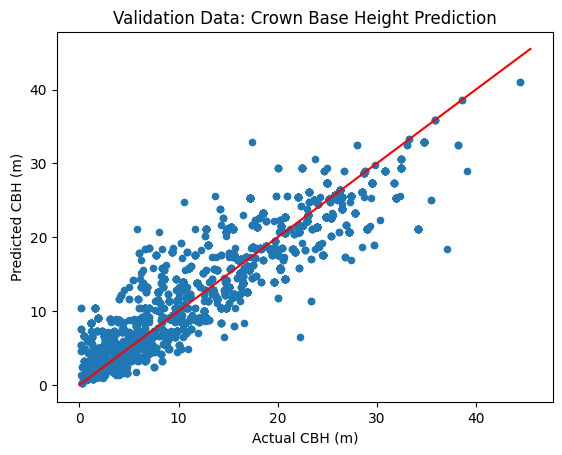

In [46]:
independent_variables = "HT"  # single predictor
dependent_variable = "CBH"

# Use a 90/10 split for training and testing (adjust as needed)
trees_train, trees_test = train_test_split(treelist[['HT', 'CBH']].dropna(), test_size=0.1)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

# Train Random Forest model for CBH prediction
model_cbh = RandomForestRegressor()
model_cbh.fit(trees_train[[independent_variables]], trees_train[dependent_variable])

# Predict CBH on test data and on ALS treetops
predicted_cbh_test = model_cbh.predict(trees_test[[independent_variables]])
predicted_cbh = model_cbh.predict(ALS_treetops_filter[[independent_variables]])

# Evaluate model performance: R^2 and RMSE on test data
r2_cbh = model_cbh.score(trees_test[[independent_variables]], trees_test[dependent_variable])
rmse_cbh = np.sqrt(((predicted_cbh_test - trees_test[dependent_variable])**2).mean())
print(f"Model R^2: {r2_cbh:.2f}")
print(f"Model RMSE: {rmse_cbh:.2f} (m)")

# Plot actual vs. predicted CBH
fig, ax = plt.subplots()
trees_test = trees_test.copy()
trees_test["predicted_cbh"] = predicted_cbh_test
trees_test.plot.scatter(x="CBH", y="predicted_cbh", ax=ax)
upper_cbh_limit = max(trees_test["CBH"].max(), trees_test["predicted_cbh"].max()) + 1
ax.plot([0, upper_cbh_limit], [0, upper_cbh_limit], color='red')
ax.set_xlabel("Actual CBH (m)")
ax.set_ylabel("Predicted CBH (m)")
ax.set_title("Validation Data: Crown Base Height Prediction")
plt.show()

Comparing with Field Data

Now that we have predicted all three tree metrics on the ALS-detected trees, we will save the predictions as a new treelist and compare these results with field-collected observations.

In [47]:
predicted_treelist = pd.DataFrame({
    'treeID': ALS_treetops_filter.treeID,
    'HT': ALS_treetops_filter.HT,
    'DIA': predicted_dbh,
    'SPCD': predicted_spcd,
    'CBH': predicted_cbh,
    'X_4326': ALS_treetops_filter.X_4326,
    'Y_4326': ALS_treetops_filter.Y_4326,
})

predicted_treelist.head()

,treeID,HT,DIA,SPCD,CBH,X_4326,Y_4326
3120,1,23.800797,55.540907,81,8.407979,-119.274157,37.108535
3121,2,16.103474,28.740294,15,6.526245,-119.274331,37.108530
3122,3,37.818615,89.018722,122,20.640655,-119.274482,37.108500
3123,4,21.019176,52.739436,81,12.121794,-119.274285,37.108481
3124,5,16.300404,28.740294,15,6.526245,-119.274088,37.108478


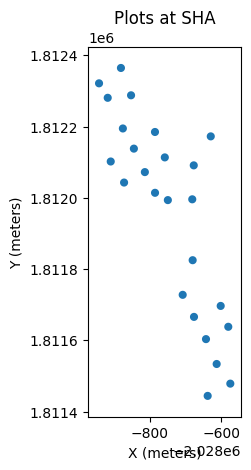

In [48]:
# Compare predictions to field data using spatial join
# Load plot boundaries and field tree data
plots_df = pd.read_csv('./01_plot_identification.csv')

# Create GeoDataFrame for plots (each unique spatial reference system is processed)
plots_intermediate = []
for srs in np.unique(plots_df.plot_coord_srs):
    plots_subset = plots_df[plots_df.plot_coord_srs == srs]
    plots_subset_gdf = gpd.GeoDataFrame(
        plots_subset, 
        geometry=gpd.points_from_xy(plots_subset.plot_coord_x, plots_subset.plot_coord_y), 
        crs=srs
    )
    # Reproject to EPSG 5070
    plots_subset_gdf = plots_subset_gdf.to_crs(5070)
    plots_intermediate.append(plots_subset_gdf)

plots_gdf = pd.concat(plots_intermediate)
plots_gdf = plots_gdf.dropna(subset=['plot_blk'])

plot_size = 1/10  # acre
acre_to_m2 = 4046.86
plot_size_m2 = plot_size * acre_to_m2
plot_radius = np.sqrt(plot_size_m2 / np.pi)
plots_gdf = plots_gdf.set_geometry(plots_gdf.buffer(plot_radius))

# Filter plots for site SHA
plots_filtered = plots_gdf[plots_gdf.site_name == site_name]
plots_filtered.plot()
plt.title(f'Plots at {site_name}')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.show()


In [49]:
predicted_treelist_gdf = gpd.GeoDataFrame(
    predicted_treelist,
    geometry=gpd.points_from_xy(predicted_treelist.X_4326, predicted_treelist.Y_4326),
    crs=4326
)
predicted_treelist_gdf = predicted_treelist_gdf.to_crs(plots_filtered.crs)

# Spatial join to assign plots to predicted trees
predicted_treelist_plots = predicted_treelist_gdf.sjoin(plots_filtered)


field_data_trees = pd.read_csv('./03_tree.csv')

plot_id = plot_names[0]
trees_filtered = field_data_trees[field_data_trees.inventory_id == plot_id]
predicted_treelist_filtered = predicted_treelist_plots[predicted_treelist_plots.inventory_id == plot_id]

predicted_treelist_filtered.head()

,treeID,HT,DIA,SPCD,CBH,X_4326,Y_4326,geometry,index_right,inventory_id,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
9545,6436,13.405090,30.773926,81,7.036213,-119.274053,37.100451,POINT (-2028674.954 1811676.71),38,100_pre_SHA_burn3d,...,100,1,40.0,5.0,1.0,33.0,1.0,1,3.0,Abigail
9563,6454,13.098443,22.465848,81,4.437432,-119.274038,37.100426,POINT (-2028674.356 1811673.73),38,100_pre_SHA_burn3d,...,100,1,40.0,5.0,1.0,33.0,1.0,1,3.0,Abigail
9567,6458,11.713481,20.281709,15,7.247664,-119.274074,37.100423,POINT (-2028677.552 1811674.188),38,100_pre_SHA_burn3d,...,100,1,40.0,5.0,1.0,33.0,1.0,1,3.0,Abigail
9588,6479,14.202027,36.443269,81,7.182681,-119.274040,37.100393,POINT (-2028675.429 1811670.091),38,100_pre_SHA_burn3d,...,100,1,40.0,5.0,1.0,33.0,1.0,1,3.0,Abigail


## Discussion

In this notebook we used the ALS-derived treelist and the FastFuels treelist as our training dataset to predict missing tree attributes (DIA, SPCD, and CBH) at Shaver Lake (SHA). Our simple models—based solely on height—perform reasonably well for lower diameters and show promise for species and CBH prediction, although additional predictors could further improve performance.

**Training Data Considerations:**  
- **FastFuels Treelist:**  
  - *Pros:* Large sample size and extensive coverage; beneficial for machine learning model training.  
  - *Cons:* May not capture local variability at SHA as accurately.
  
- **FIA Data:**  
  - *Pros:* Systematic and standardized measurements across regions.  
  - *Cons:* Sampling resolution may be coarser and less representative of the continuous landscape.
  
- **Field-Collected Data:**  
  - *Pros:* Provides site-specific measurements that can capture local conditions and variability.  
  - *Cons:* Often limited in sample size, which might reduce model generalizability.

In future iterations we may want to train separate models using FIA or field-collected data as our training dataset. Comparing RMSE, R², and classification accuracy across these models can help determine which source best suits our local prediction needs.